     C1   C2   C3   C4   C5
C1   NA 0.61 0.60 0.60 0.52
C2 0.37   NA 0.48 0.48 0.37
C3 0.37 0.49   NA 0.48 0.38
C4 0.37 0.49 0.49   NA 0.38
C5 0.44 0.60 0.59 0.59   NA


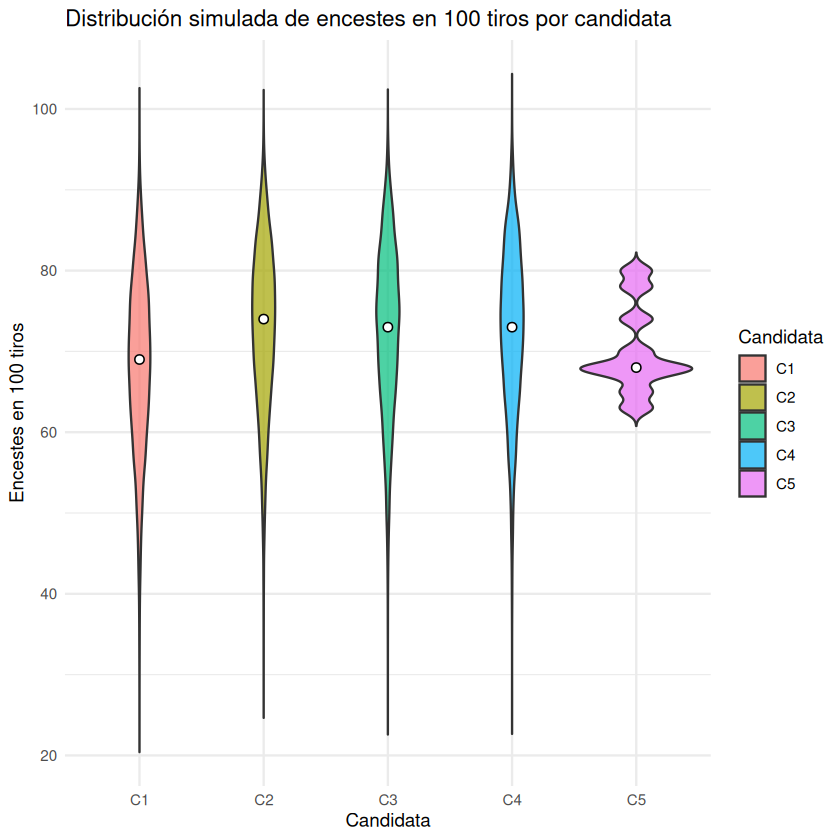

In [9]:
set.seed(100109)


library(ggplot2)
library(tidyr)
library(dplyr)

# Datos observados: tiros de jugadoras por pueblo (supuestos)
datos_jugadoras <- data.frame(
  Pueblo = rep(paste0("C", 1:4), times = c(10, 20, 30, 40)),
  Aciertos = c(
    rbinom(10, 10, 0.6),
    rbinom(20, 10, 0.6),
    rbinom(30, 10, 0.6),
    rbinom(40, 10, 0.6)
  ),
  Total = 10
)

# Calcular proporciones y tamaño muestral por jugadora
datos_jugadoras <- datos_jugadoras %>%
  mutate(Prop = Aciertos / Total)

# Estimar prior a partir de todos los datos (Empirical Bayes)
alpha0 <- mean(datos_jugadoras$Aciertos) + 1
beta0 <- mean(datos_jugadoras$Total - datos_jugadoras$Aciertos) + 1

# Seleccionamos la mejor jugadora por pueblo
mejores <- datos_jugadoras %>% group_by(Pueblo) %>% slice_max(Aciertos, with_ties = FALSE)

# Simulamos posteriors ajustadas con prior empírica
sample_posterior <- function(k, n, alpha0, beta0) {
  rbeta(10000, k + alpha0, n - k + beta0)
}

p1 <- sample_posterior(mejores$Aciertos[mejores$Pueblo == "C1"], 10, alpha0, beta0)
p2 <- sample_posterior(mejores$Aciertos[mejores$Pueblo == "C2"], 10, alpha0, beta0)
p3 <- sample_posterior(mejores$Aciertos[mejores$Pueblo == "C3"], 10, alpha0, beta0)
p4 <- sample_posterior(mejores$Aciertos[mejores$Pueblo == "C4"], 10, alpha0, beta0)

# C5: distribución empírica basada en 10 rondas reales de la misma persona
c5_rounds <- c(68, 74, 78, 70, 68, 63, 80, 68, 67, 65)

# Simulamos 10000 rondas de 100 tiros para cada candidata
test_c1 <- rbinom(10000, 100, p1)
test_c2 <- rbinom(10000, 100, p2)
test_c3 <- rbinom(10000, 100, p3)
test_c4 <- rbinom(10000, 100, p4)
test_c5 <- sample(c5_rounds, 10000, replace = TRUE)

simulaciones <- data.frame(C1 = test_c1, C2 = test_c2, C3 = test_c3, C4 = test_c4, C5 = test_c5)

# Matriz de comparación
prob_menor <- function(x, y) mean(x < y, na.rm = TRUE)
candidatas <- names(simulaciones)
comparaciones <- matrix(NA, 5, 5, dimnames = list(candidatas, candidatas))
for (i in candidatas) {
  for (j in candidatas) {
    if (i != j) {
      comparaciones[i, j] <- prob_menor(simulaciones[[i]], simulaciones[[j]])
    }
  }
}

print(round(comparaciones, 2))

# Violin plot de distribuciones
simulaciones_long <- pivot_longer(simulaciones, cols = everything(), names_to = "Candidata", values_to = "Encestes") %>%
  drop_na()

ggplot(simulaciones_long, aes(x = Candidata, y = Encestes, fill = Candidata)) +
  geom_violin(trim = FALSE, alpha = 0.7) +
  stat_summary(fun = median, geom = "point", shape = 21, size = 2, fill = "white") +
  theme_minimal() +
  labs(title = "Distribución simulada de encestes en 100 tiros por candidata",
       y = "Encestes en 100 tiros", x = "Candidata")
